In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
from bt_tools import get_df, performance_analysis, trend_follow_sigs
import requests
from bs4 import BeautifulSoup, NavigableString, Tag
import re
import pandas as pd
import numpy as np
import json

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mstats
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1


In [ ]:
df = pd.read_pickle('closes_sp500_2020-09-15.pkl') # temp_close_stoxx600

df.ffill(inplace=True)
df.dropna(how='all', axis=1, inplace=True)

df.sort_index(inplace=True)
today = pd.datetime.today().date()

## Since you can't run this
# df = df[today - pd.Timedelta('6Y'):]


df = df["-".join([str(today.year-6), str(today.month), str(today.day)]):]


## Data Quality issue
# df.loc['2020-07-22', 'CRDA.L'] = 5616.00

## Rerun all cells to modify weekly transaction cost (return based)
transaction_cost =  0.000 #0.0010

In [ ]:
## Construct Signals
df_20MA = df.rolling(20).mean().fillna(0)
df_50MA = df.rolling(50).mean().fillna(0)
df_150MA = df.rolling(150).mean().fillna(0)

## Since you can't run this
# stoxx600 = pd.read_pickle('stoxx600.pkl')['Close'][today - pd.Timedelta('5Y'):]

five_yrs_ago_date = "-".join([str(today.year-5), str(today.month), str(today.day)])
sp500 = yf.Ticker('SPY')
sp500 = sp500.history(period="max")['Close']
ret_sp500 = sp500.pct_change().fillna(0)
eq_curve_sp500 = (ret_sp500+ 1).cumprod()


## Requested Portfolio
## Long trend following, short index
## equal weighted in stocks, and long short


binary_signal = (df_20MA > df_50MA)&(df_50MA>df_150MA)
ret_df = df[five_yrs_ago_date:].pct_change(1).fillna(0)

arr_transaction_cost = [0,0,0,0,transaction_cost]*(len(ret_df.index)//5) + [0]*(len(ret_df.index)%5)


holdings = binary_signal.shift(1)[five_yrs_ago_date:]
w = holdings.sum(axis=1)
w=(1/w).replace([np.inf, -np.inf], 0)


port_ret = ((ret_df*holdings.mul(w, axis='index')).sum(axis=1) - pd.Series(arr_transaction_cost, index=w.index)).rename('Long').to_frame()
port_ret['Short'] = ret_sp500

port_ret = port_ret.fillna(0)

ew_eq_curve = (port_ret+1).cumprod()


In [ ]:
## Long/ Short Side Plot
ew_eq_curve.plot(figsize=(100,50), legend=True)
plt.show()
plt.close()

In [ ]:
## combined PnL

combined_PnL = (port_ret['Long'] - port_ret['Short'] + 1).cumprod()
combined_PnL.plot(figsize=(100,50), legend=True)

plt.show()
plt.close()

In [8]:
combined_PnL.pct_change(1).skew()

-0.1872282895519116

In [9]:
combined_PnL.pct_change(1).describe()

count    1260.000000
mean        0.000365
std         0.010407
min        -0.073935
25%        -0.004199
50%         0.000630
75%         0.005132
max         0.063389
dtype: float64

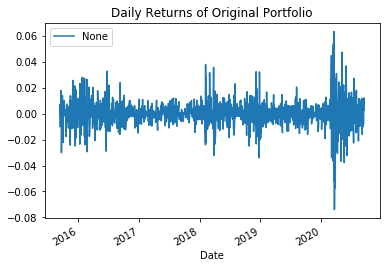

Ending Equity/ Profitability
Date
2020-09-15    1.478521
dtype: float64
count    1260.000000
mean        0.000365
std         0.010407
min        -0.073935
25%        -0.004199
50%         0.000630
75%         0.005132
max         0.063389
dtype: float64


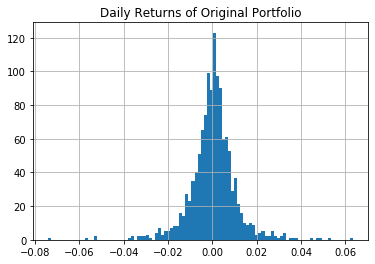

strategy alpha beta
                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     424.9
Date:                Tue, 15 Sep 2020   Prob (F-statistic):           1.43e-81
Time:                        17:53:51   Log-Likelihood:                 4148.2
No. Observations:                1260   AIC:                            -8292.
Df Residuals:                    1258   BIC:                            -8282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000

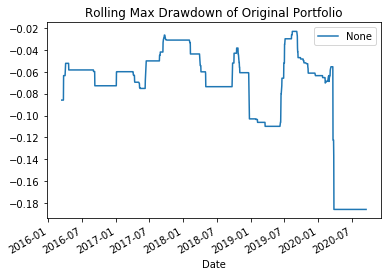

max dd: -0.18595926500711857
IR
Date
2015-12-31         NaN
2016-12-31    5.671287
2017-12-31    0.646434
2018-12-31    6.300582
2019-12-31   -8.391461
2020-12-31    6.408731
Freq: A-DEC, dtype: float64
2.1271146403774495
Profit       1.478521
Alpha        0.000399
Beta        -0.470247
Daily Vol    0.010407
MaxDD       -0.185959
IR           2.127115
dtype: float64


Profit       1.478521
Alpha        0.000399
Beta        -0.470247
Daily Vol    0.010407
MaxDD       -0.185959
IR           2.127115
dtype: float64

In [10]:
performance_analysis(combined_PnL, (port_ret['Short'] + 1).cumprod(), port_name="Original Portfolio")

In [40]:
## what if we seperate the two trend trading rules, what the portfolio will look like?
signal_20_50 = df_20MA - df_50MA
signal_50_150 = df_50MA - df_150MA


holdings_20_50 = np.sign(signal_20_50).replace(-1, 0)[five_yrs_ago_date:]
holdings_50_150 = np.sign(signal_50_150).replace(-1, 0)[five_yrs_ago_date:]

w_20_50 = (1/holdings_20_50.sum(axis=1)).replace([np.inf, -np.inf], 0)
w_50_150 = (1/holdings_50_150.sum(axis=1)).replace([np.inf, -np.inf], 0)


arr_transaction_cost = [0,0,0,0,transaction_cost]*(len(ret_df.index)//5) + [0]*(len(ret_df.index)%5)


port_ret_20_50 = ((ret_df*holdings_20_50.mul(w_20_50, axis='index')).sum(axis=1) - ret_sp500 - pd.Series(arr_transaction_cost, index=w.index)).fillna(0)
port_ret_50_150 = ((ret_df*holdings_50_150.mul(w_50_150, axis='index')).sum(axis=1) - ret_sp500 - pd.Series(arr_transaction_cost, index=w.index)).fillna(0)
            
            
ew_eq_curve_20_50 = (port_ret_20_50+1).cumprod()
ew_eq_curve_50_150 = (port_ret_50_150+1).cumprod()


In [41]:
len([0,0,0,0,transaction_cost]*(len(ret_df.index)//5) + [0]*(len(ret_df.index)%5))

1261

In [42]:
ew_eq_curve_20_50_150 = ew_eq_curve_20_50.rename('20_50').to_frame()
ew_eq_curve_20_50_150['50_150'] = ew_eq_curve_50_150
ew_eq_curve_20_50_150["original"] = combined_PnL


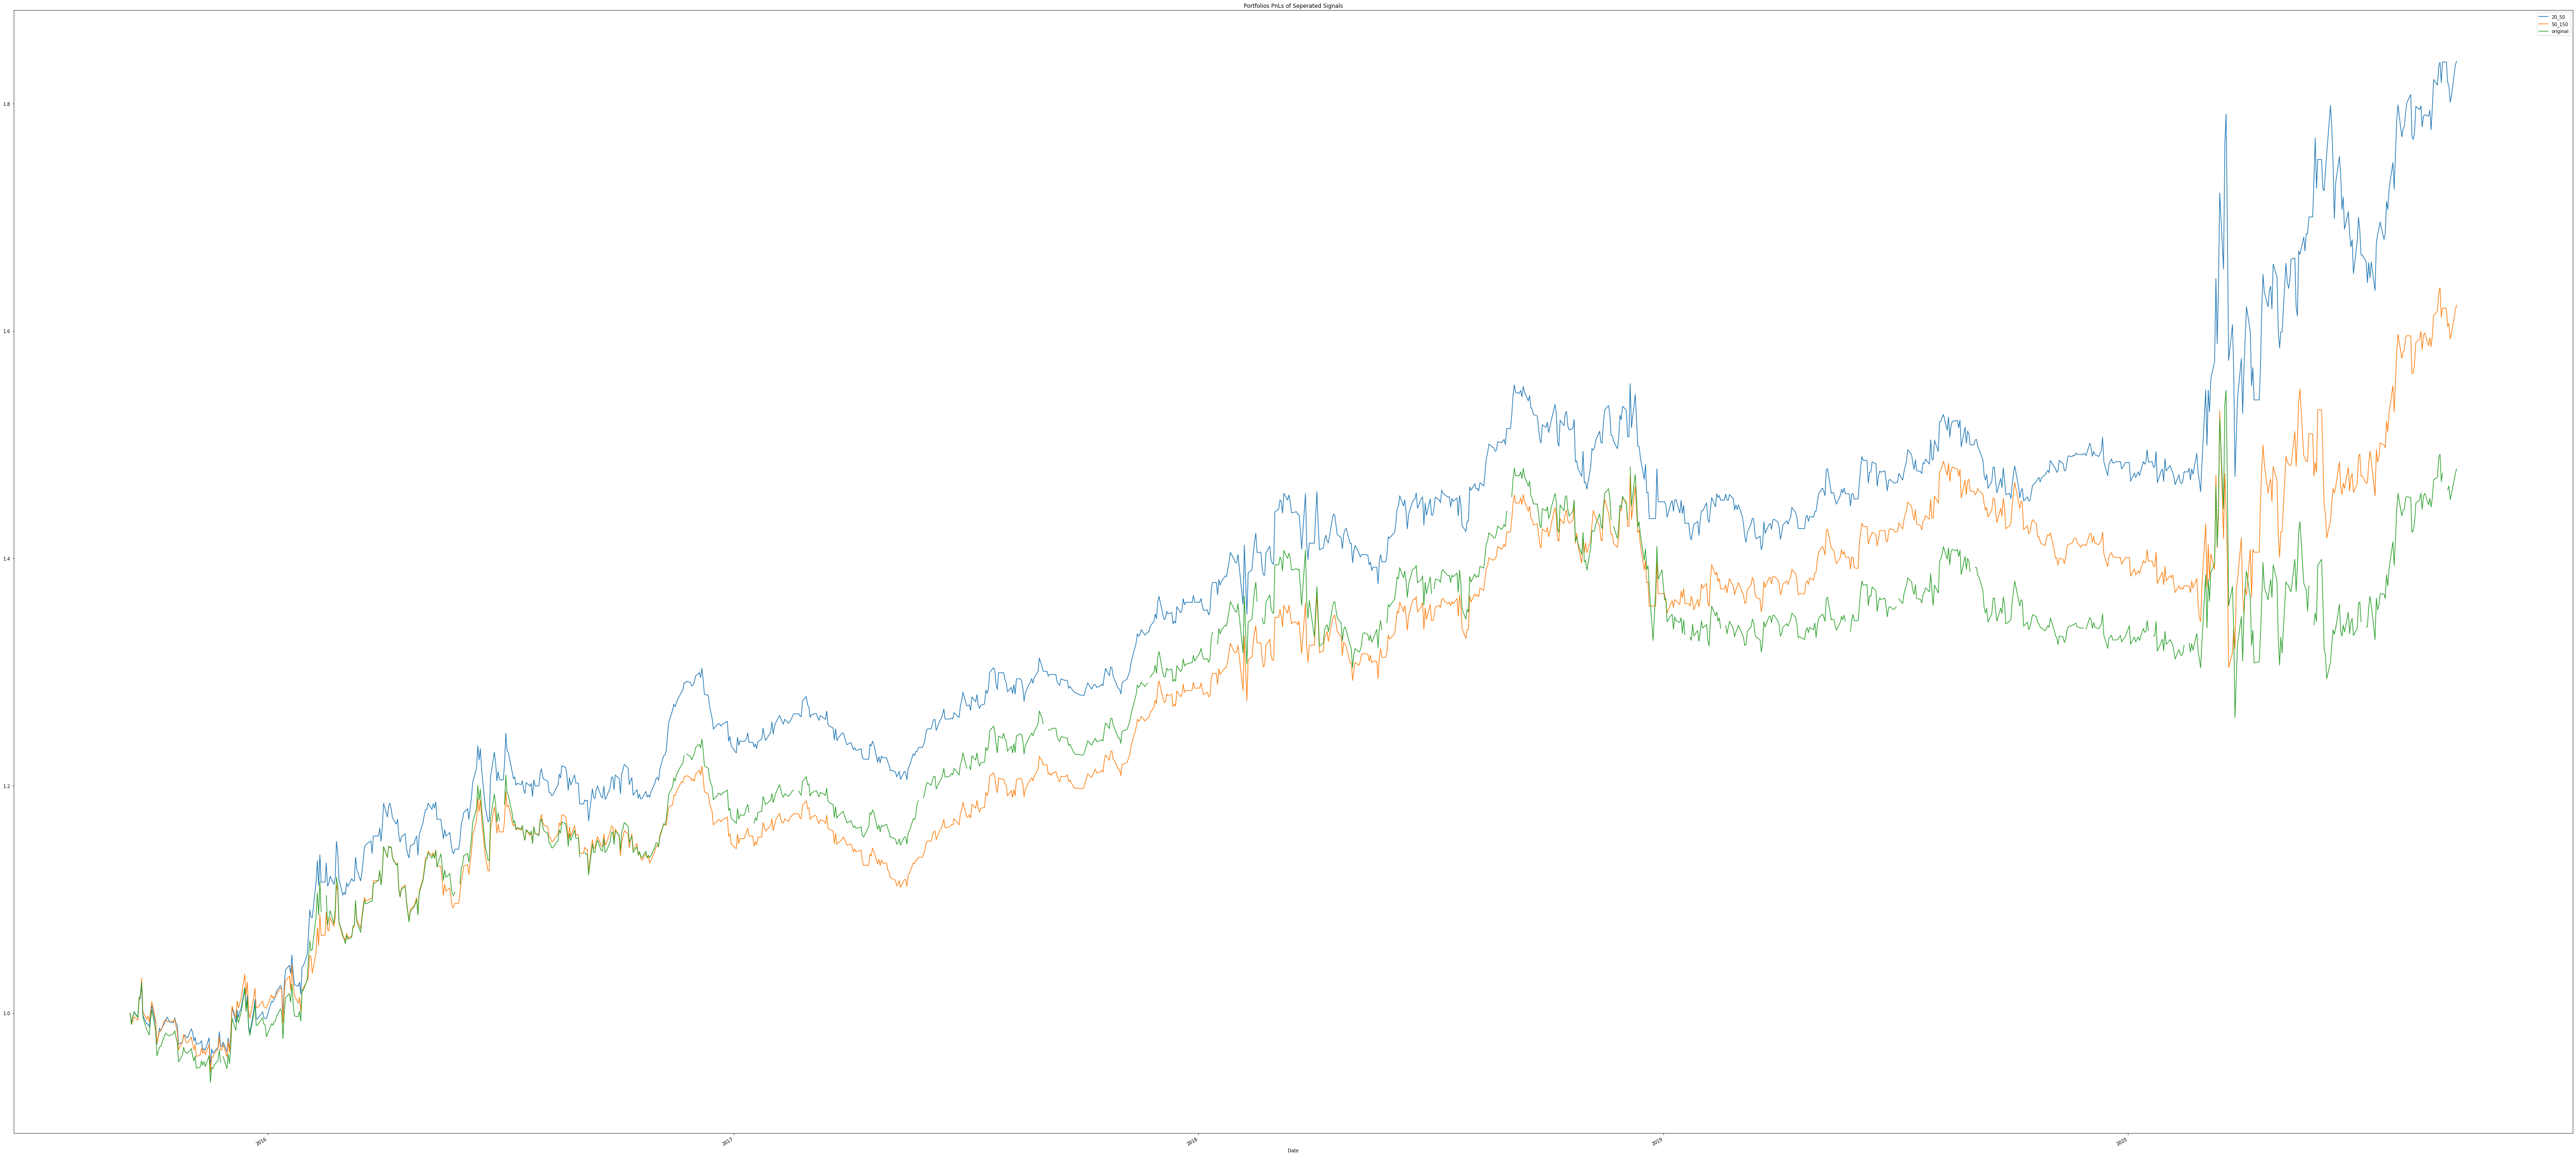

In [43]:
ew_eq_curve_20_50_150.plot(figsize=(100,50), legend=True, title="Portfolios PnLs of Seperated Signals")
plt.show()
plt.close()


We also discovered a most likely data quality issue, from yahoo finance
seems like two decimal points are missing for CRDA.L
We'll edit it for now and rerun previous analysis







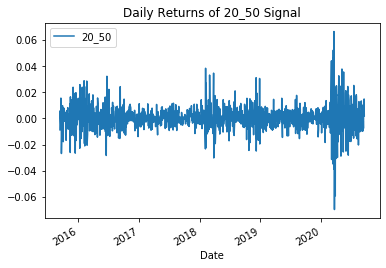

Ending Equity/ Profitability
Date
2020-09-15    1.837146
Name: 20_50, dtype: float64
count    1290.000000
mean        0.000519
std         0.009753
min        -0.069697
25%        -0.003698
50%         0.000100
75%         0.004784
max         0.066355
Name: 20_50, dtype: float64


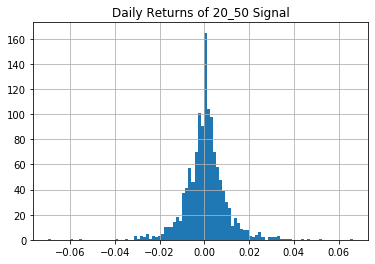

strategy alpha beta
                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     342.9
Date:                Tue, 15 Sep 2020   Prob (F-statistic):           6.89e-68
Time:                        19:24:15   Log-Likelihood:                 4183.8
No. Observations:                1260   AIC:                            -8364.
Df Residuals:                    1258   BIC:                            -8353.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000

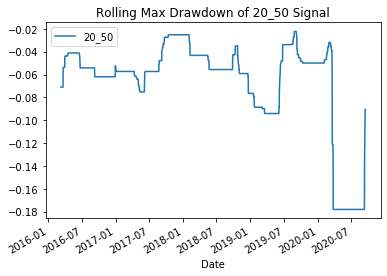

max dd: -0.17798399689023747
IR
Date
2015-12-31         NaN
2016-12-31    6.759020
2017-12-31    0.239139
2018-12-31    5.762065
2019-12-31   -7.808223
2020-12-31    5.466982
Freq: A-DEC, dtype: float64
2.0837965993204213
Profit       1.837146
Alpha        0.000562
Beta        -0.410669
Daily Vol    0.009753
MaxDD       -0.177984
IR           2.083797
dtype: float64


Profit       1.837146
Alpha        0.000562
Beta        -0.410669
Daily Vol    0.009753
MaxDD       -0.177984
IR           2.083797
dtype: float64

In [44]:
performance_analysis(ew_eq_curve_20_50_150['20_50'], (port_ret['Short'] + 1).cumprod(), port_name="20_50 Signal")


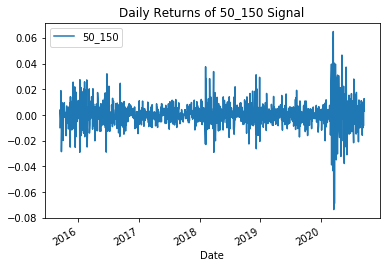

Ending Equity/ Profitability
Date
2020-09-15    1.622751
Name: 50_150, dtype: float64
count    1290.000000
mean        0.000424
std         0.009884
min        -0.073521
25%        -0.003977
50%         0.000130
75%         0.004816
max         0.064902
Name: 50_150, dtype: float64


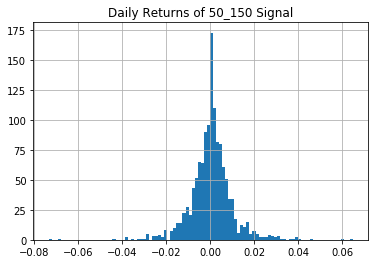

strategy alpha beta
                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     234.3
Date:                Tue, 15 Sep 2020   Prob (F-statistic):           1.27e-48
Time:                        19:24:18   Log-Likelihood:                 4122.6
No. Observations:                1260   AIC:                            -8241.
Df Residuals:                    1258   BIC:                            -8231.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000

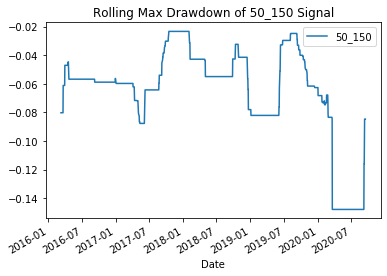

max dd: -0.14770809248525552
IR
Date
2015-12-31         NaN
2016-12-31    6.188646
2017-12-31    0.691826
2018-12-31    5.882618
2019-12-31   -7.797758
2020-12-31    7.652270
Freq: A-DEC, dtype: float64
2.52352041302104
Profit       1.622751
Alpha        0.000460
Beta        -0.356322
Daily Vol    0.009884
MaxDD       -0.147708
IR           2.523520
dtype: float64


Profit       1.622751
Alpha        0.000460
Beta        -0.356322
Daily Vol    0.009884
MaxDD       -0.147708
IR           2.523520
dtype: float64

In [45]:
performance_analysis(ew_eq_curve_20_50_150['50_150'], (port_ret['Short'] + 1).cumprod(), port_name="50_150 Signal")

In [46]:
sep_signal_ret = port_ret_20_50.rename('20_50').to_frame()
sep_signal_ret['50_150'] = port_ret_50_150

/Users/kingf.wong/.conda/envs/FinanceML/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


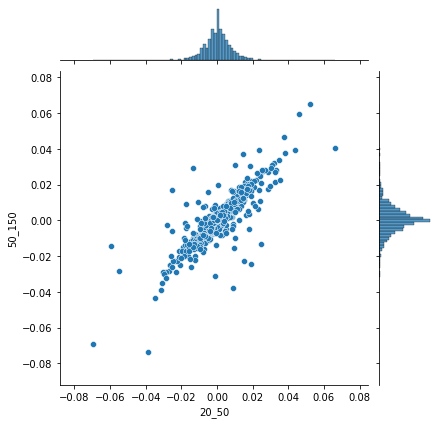

In [47]:
## The returns of the trading are plagued by outliers
sns.jointplot(sep_signal_ret['20_50'],sep_signal_ret['50_150'])

In [48]:
## Can remove the outliers by winsorizing 
sep_signal_ret = pd.DataFrame(mstats.winsorize(sep_signal_ret, [0.05, 0.05]), index=sep_signal_ret.index, columns=sep_signal_ret.columns)

/Users/kingf.wong/.conda/envs/FinanceML/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


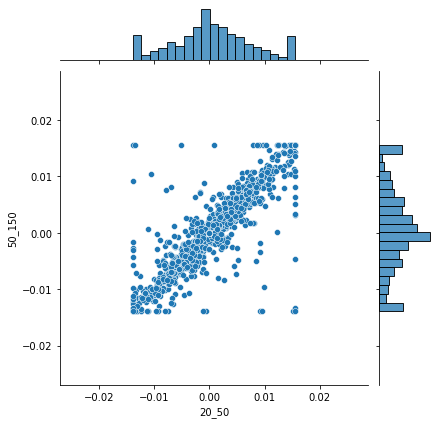

In [49]:
sns.jointplot(sep_signal_ret['20_50'],sep_signal_ret['50_150'])

In [50]:
sep_signal_ret.corr()

,20_50,50_150
20_50,1.000000,0.882746
50_150,0.882746,1.000000


In [51]:
def compute_MV_weights(cov_m):
    inv_covar = np.linalg.inv(cov_m)
    u = np.ones(len(cov_m))
    return np.dot(inv_covar, u) / np.dot(u, np.dot(inv_covar, u))

In [52]:
## adjust by price volatility, so big moves of slow movers weight more than big moves of big movers
std_df = ret_df.rolling(60).std()
price_vol = df*std_df

In [53]:
## try to build different portfolios to see if there's improvement with different weighting scheme


signal_20_50 = df_20MA - df_50MA
signal_50_150 = df_50MA -df_150MA

norm_signal_20_50 = ((signal_20_50)/price_vol).replace([np.inf, -np.inf, np.nan],0)
norm_signal_50_150 = ((signal_50_150)/price_vol).replace([np.inf, -np.inf, np.nan],0)

## we can weight the two signals by inversing the covariance matrix of the seperated portfolio returns, will ignore insample calculation for now


w_trading_rules = compute_MV_weights(sep_signal_ret.cov())
w_trading_rules

array([0.50229527, 0.49770473])

In [54]:
combined_signal = norm_signal_20_50*w_trading_rules[0] + norm_signal_50_150*w_trading_rules[1]

In [55]:
combined_signal.describe()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
count,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,...,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000,1513.000000
mean,1.491682,-0.776083,-0.327181,1.720816,0.708269,-0.148042,1.082556,1.365774,1.555006,2.190331,...,0.806075,-0.547953,-0.197372,-0.203824,1.444281,1.286339,0.595542,1.138639,0.251134,1.893298
std,2.215804,2.423931,2.749145,2.957800,2.536882,1.859392,3.192542,2.110620,2.207095,2.315204,...,1.946979,2.159220,2.779392,2.388462,2.473933,2.511788,2.217760,2.345039,2.720750,2.038655
min,-3.231748,-8.316666,-10.169357,-4.974206,-3.596296,-6.198018,-7.452182,-4.020011,-3.261269,-1.556436,...,-4.250362,-9.447577,-7.681712,-7.186901,-2.705932,-6.790062,-5.142521,-7.010981,-9.663643,-2.887089
25%,0.000000,-1.976254,-1.842029,0.000000,-1.272900,-1.054862,-0.893087,0.000000,0.000000,0.000000,...,0.000000,-1.892039,-1.418087,-1.113427,-0.072757,0.000000,-0.731561,0.000000,-0.951144,0.000000
50%,0.790049,-0.214469,0.000000,1.605445,0.000000,0.000000,0.000000,0.964148,0.903839,2.062102,...,0.447898,-0.158064,0.000000,0.000000,0.400805,0.907924,0.000000,1.056686,0.000000,1.678589
75%,3.366021,0.005232,1.260240,3.326893,2.660105,0.934162,4.277543,2.951014,2.916896,3.635932,...,2.295568,0.325628,1.557165,1.206187,3.095194,2.998502,2.238873,2.836369,1.967324,3.460943
max,7.036600,5.883245,6.858534,9.708208,6.598244,5.013735,7.855870,6.149343,8.753509,9.906615,...,7.834990,5.625860,7.894330,5.696772,7.982668,6.531690,7.311629,6.045128,6.761988,7.008034


In [56]:
def simple_ew_backtester(bt_signal_df, bt_ret_df, b_ret, rules=0, transaction_cost=transaction_cost):
    
    bt_signal_df = bt_signal_df.where(bt_signal_df < rules,np.inf)
    bt_signal_df = bt_signal_df.where(bt_signal_df > rules,np.nan)
    bt_signal_df = bt_signal_df.replace(np.inf,1).fillna(0)

    bt_holdings = bt_signal_df.shift(1)[five_yrs_ago_date:]
    bt_w = (1/bt_holdings.sum(axis=1)).replace([np.inf, -np.inf], 0)


    arr_transaction_cost = [0,0,0,0,transaction_cost]*(len(ret_df.index)//5) + [0]*(len(ret_df.index)%5)
    
    
    
    bt_port_ret = (bt_ret_df*holdings.mul(bt_w, axis='index')).sum(axis=1) - b_ret - pd.Series(arr_transaction_cost, index=w.index)
    bt_ew_eq_curve = (bt_port_ret.fillna(0)+1).cumprod()
    

    return bt_port_ret, bt_ew_eq_curve
    
    
    
    
    

In [57]:
combined_ew_ret_0, combined_ew_eq_curve_0 = simple_ew_backtester(combined_signal, ret_df, ret_stoxx600, rules=0, transaction_cost=transaction_cost)
combined_ew_ret_1, combined_ew_eq_curve_1 = simple_ew_backtester(combined_signal, ret_df, ret_stoxx600, rules=1, transaction_cost=transaction_cost)
combined_ew_ret_2, combined_ew_eq_curve_2 = simple_ew_backtester(combined_signal, ret_df, ret_stoxx600, rules=2, transaction_cost=transaction_cost)

In [58]:

ew_eq_curve_20_50_150['ew_mv_signal_0'] = combined_ew_eq_curve_0
ew_eq_curve_20_50_150['ew_mv_signal_1'] = combined_ew_eq_curve_1
ew_eq_curve_20_50_150['ew_mv_signal_2'] = combined_ew_eq_curve_2

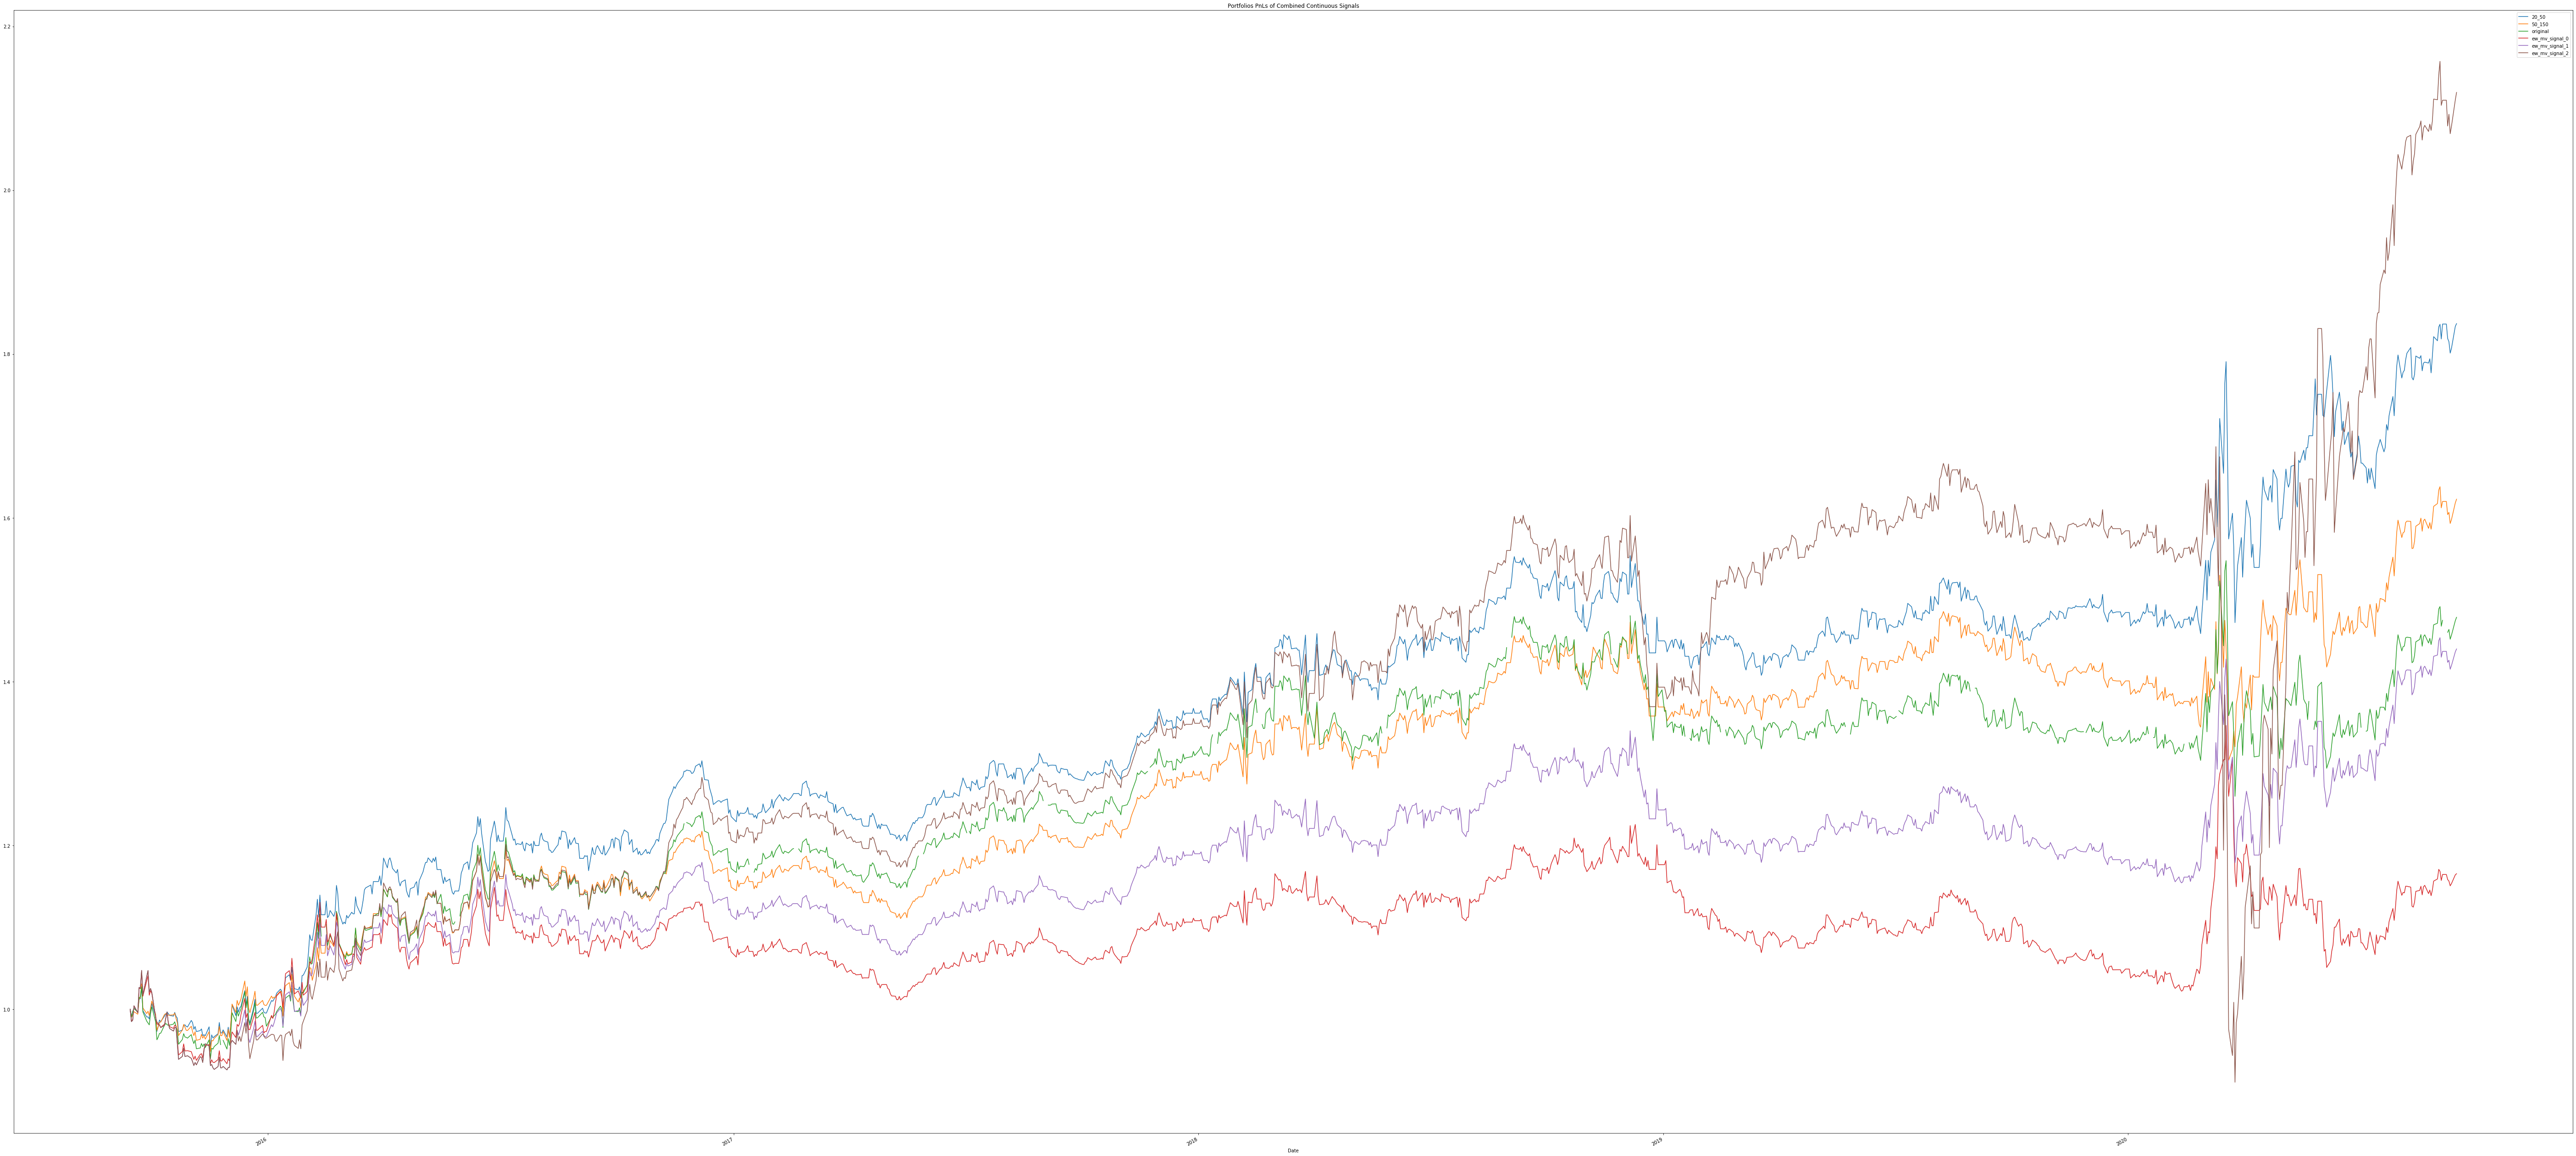

In [59]:
ew_eq_curve_20_50_150.plot(figsize=(100,50), legend=True, title="Portfolios PnLs of Combined Continuous Signals")
plt.show()
plt.close()

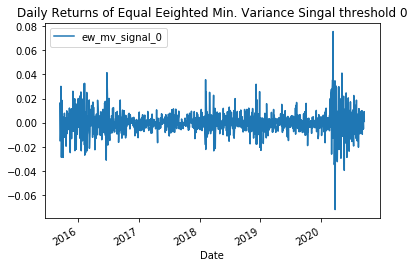

Ending Equity/ Profitability
Date
2020-09-15    1.162532
Name: ew_mv_signal_0, dtype: float64
count    1290.000000
mean        0.000160
std         0.009334
min        -0.071813
25%        -0.003941
50%         0.000000
75%         0.003892
max         0.075550
Name: ew_mv_signal_0, dtype: float64


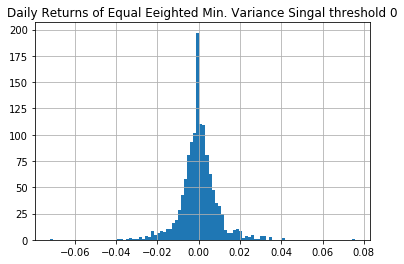

strategy alpha beta
                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     3441.
Date:                Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                        17:54:21   Log-Likelihood:                 4917.3
No. Observations:                1260   AIC:                            -9831.
Df Residuals:                    1258   BIC:                            -9820.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000

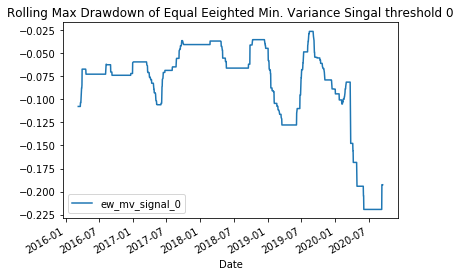

max dd: -0.21933251650991414
IR
Date
2015-12-31         NaN
2016-12-31    3.421813
2017-12-31   -1.907033
2018-12-31    6.914892
2019-12-31   -8.652941
2020-12-31    3.933689
Freq: A-DEC, dtype: float64
0.7420841242330474
Profit       1.162532
Alpha        0.000217
Beta        -0.726771
Daily Vol    0.009334
MaxDD       -0.219333
IR           0.742084
dtype: float64


Profit       1.162532
Alpha        0.000217
Beta        -0.726771
Daily Vol    0.009334
MaxDD       -0.219333
IR           0.742084
dtype: float64

In [31]:
performance_analysis(ew_eq_curve_20_50_150['ew_mv_signal_0'], (port_ret['Short'] + 1).cumprod(), port_name="Equal Eeighted Min. Variance Singal threshold 0")

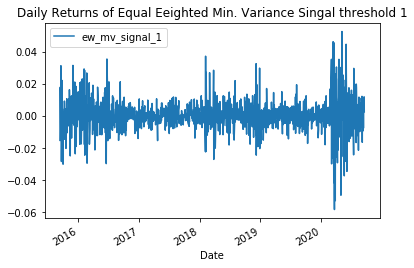

Ending Equity/ Profitability
Date
2020-09-15    1.437918
Name: ew_mv_signal_1, dtype: float64
count    1290.000000
mean        0.000331
std         0.009944
min        -0.058331
25%        -0.003879
50%         0.000033
75%         0.004423
max         0.052480
Name: ew_mv_signal_1, dtype: float64


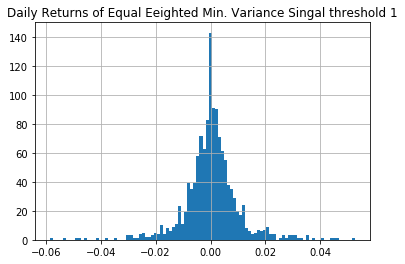

strategy alpha beta
                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     846.5
Date:                Tue, 15 Sep 2020   Prob (F-statistic):          9.71e-143
Time:                        17:54:23   Log-Likelihood:                 4331.6
No. Observations:                1260   AIC:                            -8659.
Df Residuals:                    1258   BIC:                            -8649.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000

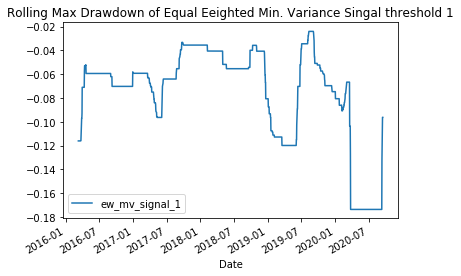

max dd: -0.17353747829470878
IR
Date
2015-12-31         NaN
2016-12-31    3.946039
2017-12-31   -0.713515
2018-12-31    5.493594
2019-12-31   -8.805121
2020-12-31    5.680069
Freq: A-DEC, dtype: float64
1.1202132060482755
Profit       1.437918
Alpha        0.000381
Beta        -0.573801
Daily Vol    0.009944
MaxDD       -0.173537
IR           1.120213
dtype: float64


Profit       1.437918
Alpha        0.000381
Beta        -0.573801
Daily Vol    0.009944
MaxDD       -0.173537
IR           1.120213
dtype: float64

In [32]:
performance_analysis(ew_eq_curve_20_50_150['ew_mv_signal_1'], (port_ret['Short'] + 1).cumprod(), port_name="Equal Eeighted Min. Variance Singal threshold 1")

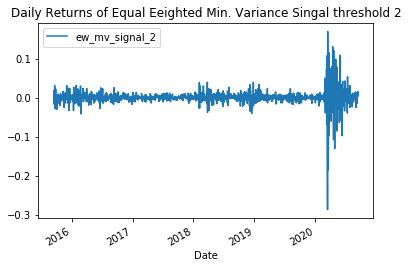

Ending Equity/ Profitability
Date
2020-09-15    2.113983
Name: ew_mv_signal_2, dtype: float64
count    1290.000000
mean        0.000785
std         0.019849
min        -0.286957
25%        -0.004162
50%         0.000207
75%         0.005904
max         0.169643
Name: ew_mv_signal_2, dtype: float64


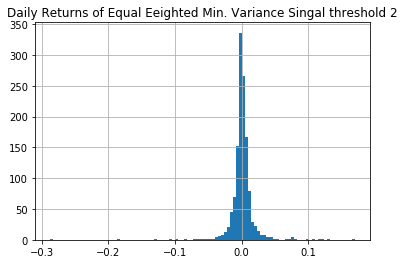

strategy alpha beta
                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.500
Date:                Tue, 15 Sep 2020   Prob (F-statistic):             0.0616
Time:                        17:54:25   Log-Likelihood:                 3138.3
No. Observations:                1260   AIC:                            -6273.
Df Residuals:                    1258   BIC:                            -6262.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001

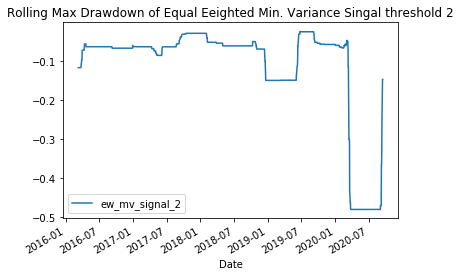

max dd: -0.4796413490483902
IR
Date
2015-12-31         NaN
2016-12-31    4.189972
2017-12-31    0.523238
2018-12-31    3.026400
2019-12-31   -1.742238
2020-12-31    2.595302
Freq: A-DEC, dtype: float64
1.7185347612654915
Profit       2.113983
Alpha        0.000811
Beta        -0.095119
Daily Vol    0.019849
MaxDD       -0.479641
IR           1.718535
dtype: float64


Profit       2.113983
Alpha        0.000811
Beta        -0.095119
Daily Vol    0.019849
MaxDD       -0.479641
IR           1.718535
dtype: float64

In [33]:
performance_analysis(ew_eq_curve_20_50_150['ew_mv_signal_2'], (port_ret['Short'] + 1).cumprod(), port_name="Equal Eeighted Min. Variance Singal threshold 2")

In [34]:
def simple_mv_backtester(bt_signal_df, ret_df, min_periods=20, rules=1.645):
    
    bt_signal_df = bt_signal_df.where(bt_signal_df < rules,np.inf)
    bt_signal_df = bt_signal_df.where(bt_signal_df > rules,np.nan)
    bt_signal_df = bt_signal_df.replace(np.inf,1).dropna(how='all', axis=1).fillna(0)
    bt_holdings = bt_signal_df.shift(1)[five_yrs_ago_date:]
    
    bt_ret_df = ret_df*bt_holdings
    bt_ret_df = ret_df.replace(-0,0)

    
    ## to avoid sigular matrix error due to zero prices returns, adding tiny tiny nois to the covariance matrix
    noised_bt_ret_df = bt_ret_df+0.00000001*np.random.rand(*bt_ret_df.shape)
    noised_bt_ret_df = noised_bt_ret_df.dropna(how='all', axis=1).fillna(0)
    cov_df = noised_bt_ret_df.expanding( min_periods=min_periods).cov().dropna(axis=0) # window=min_periods,
    

    w_MV = cov_df.groupby(level=0, axis=0).apply(compute_MV_weights).apply(pd.Series)
    
    w_MV.columns = cov_df.columns
    
    bt_port_ret = (bt_ret_df.mul(w_MV, axis='index').fillna(0)).sum(axis=1) 
    bt_mv_eq_curve = (bt_port_ret.fillna(0)+1).cumprod()
    

    return bt_port_ret, bt_mv_eq_curve
    
    
    

In [35]:
mv_port_ret_2, mv_eq_curv_2 = simple_mv_backtester(combined_signal, ret_df, rules=2)


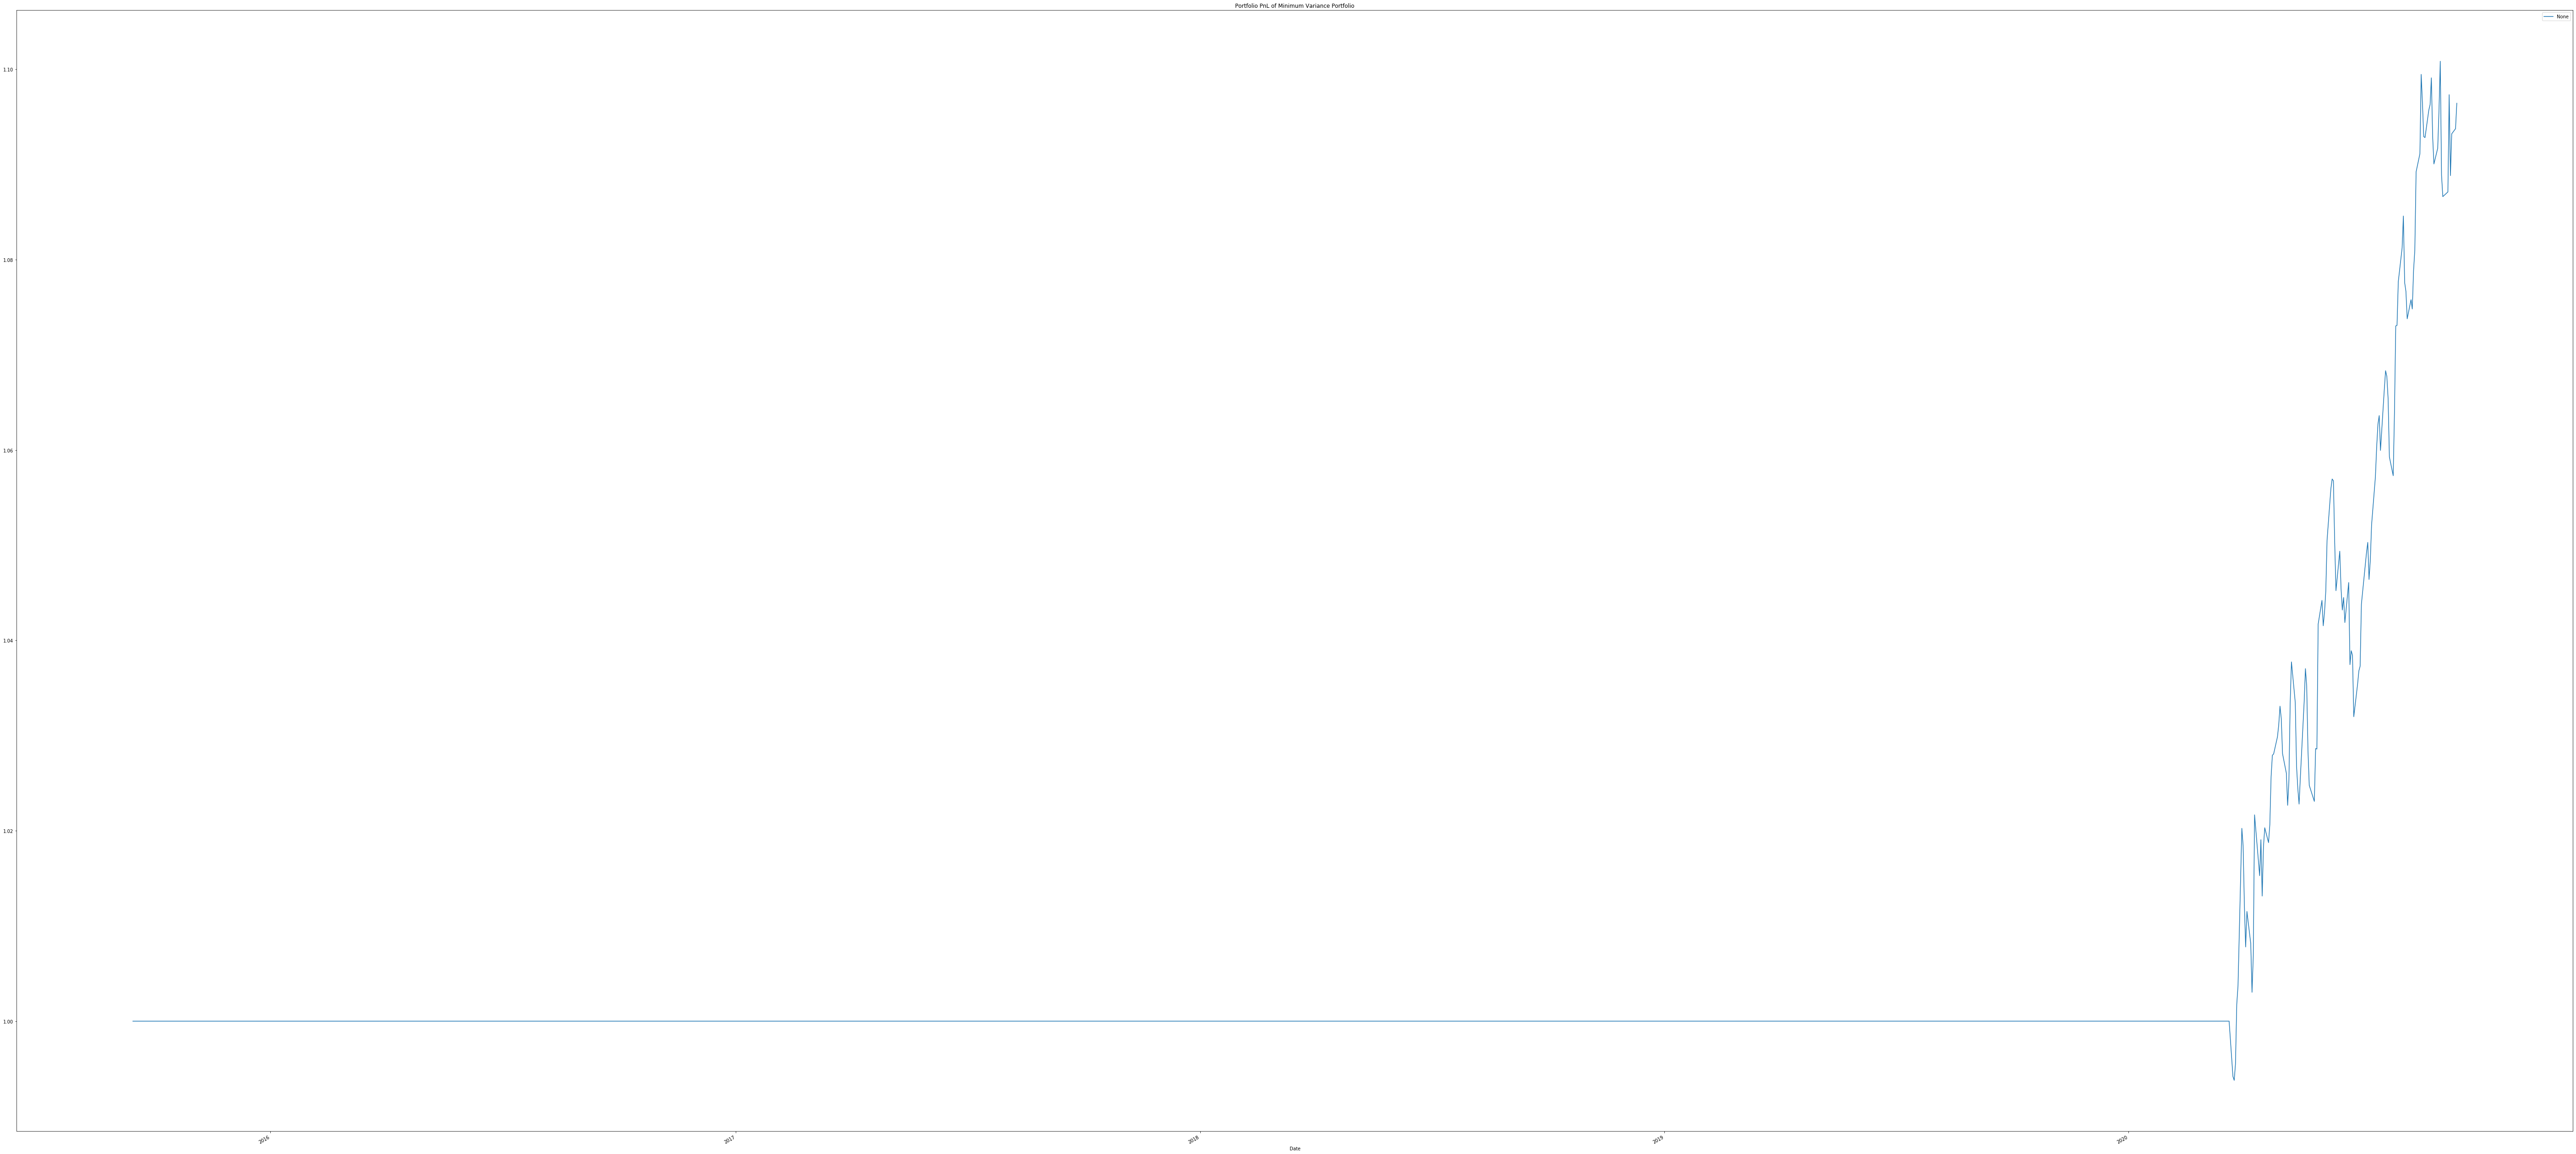

In [36]:
mv_eq_curv_2.plot(figsize=(100,50), legend=True,title="Portfolio PnL of Minimum Variance Portfolio")
plt.show()
plt.close()

In [37]:
ew_eq_curve_20_50_150['MV_port_2'] = mv_eq_curv_2

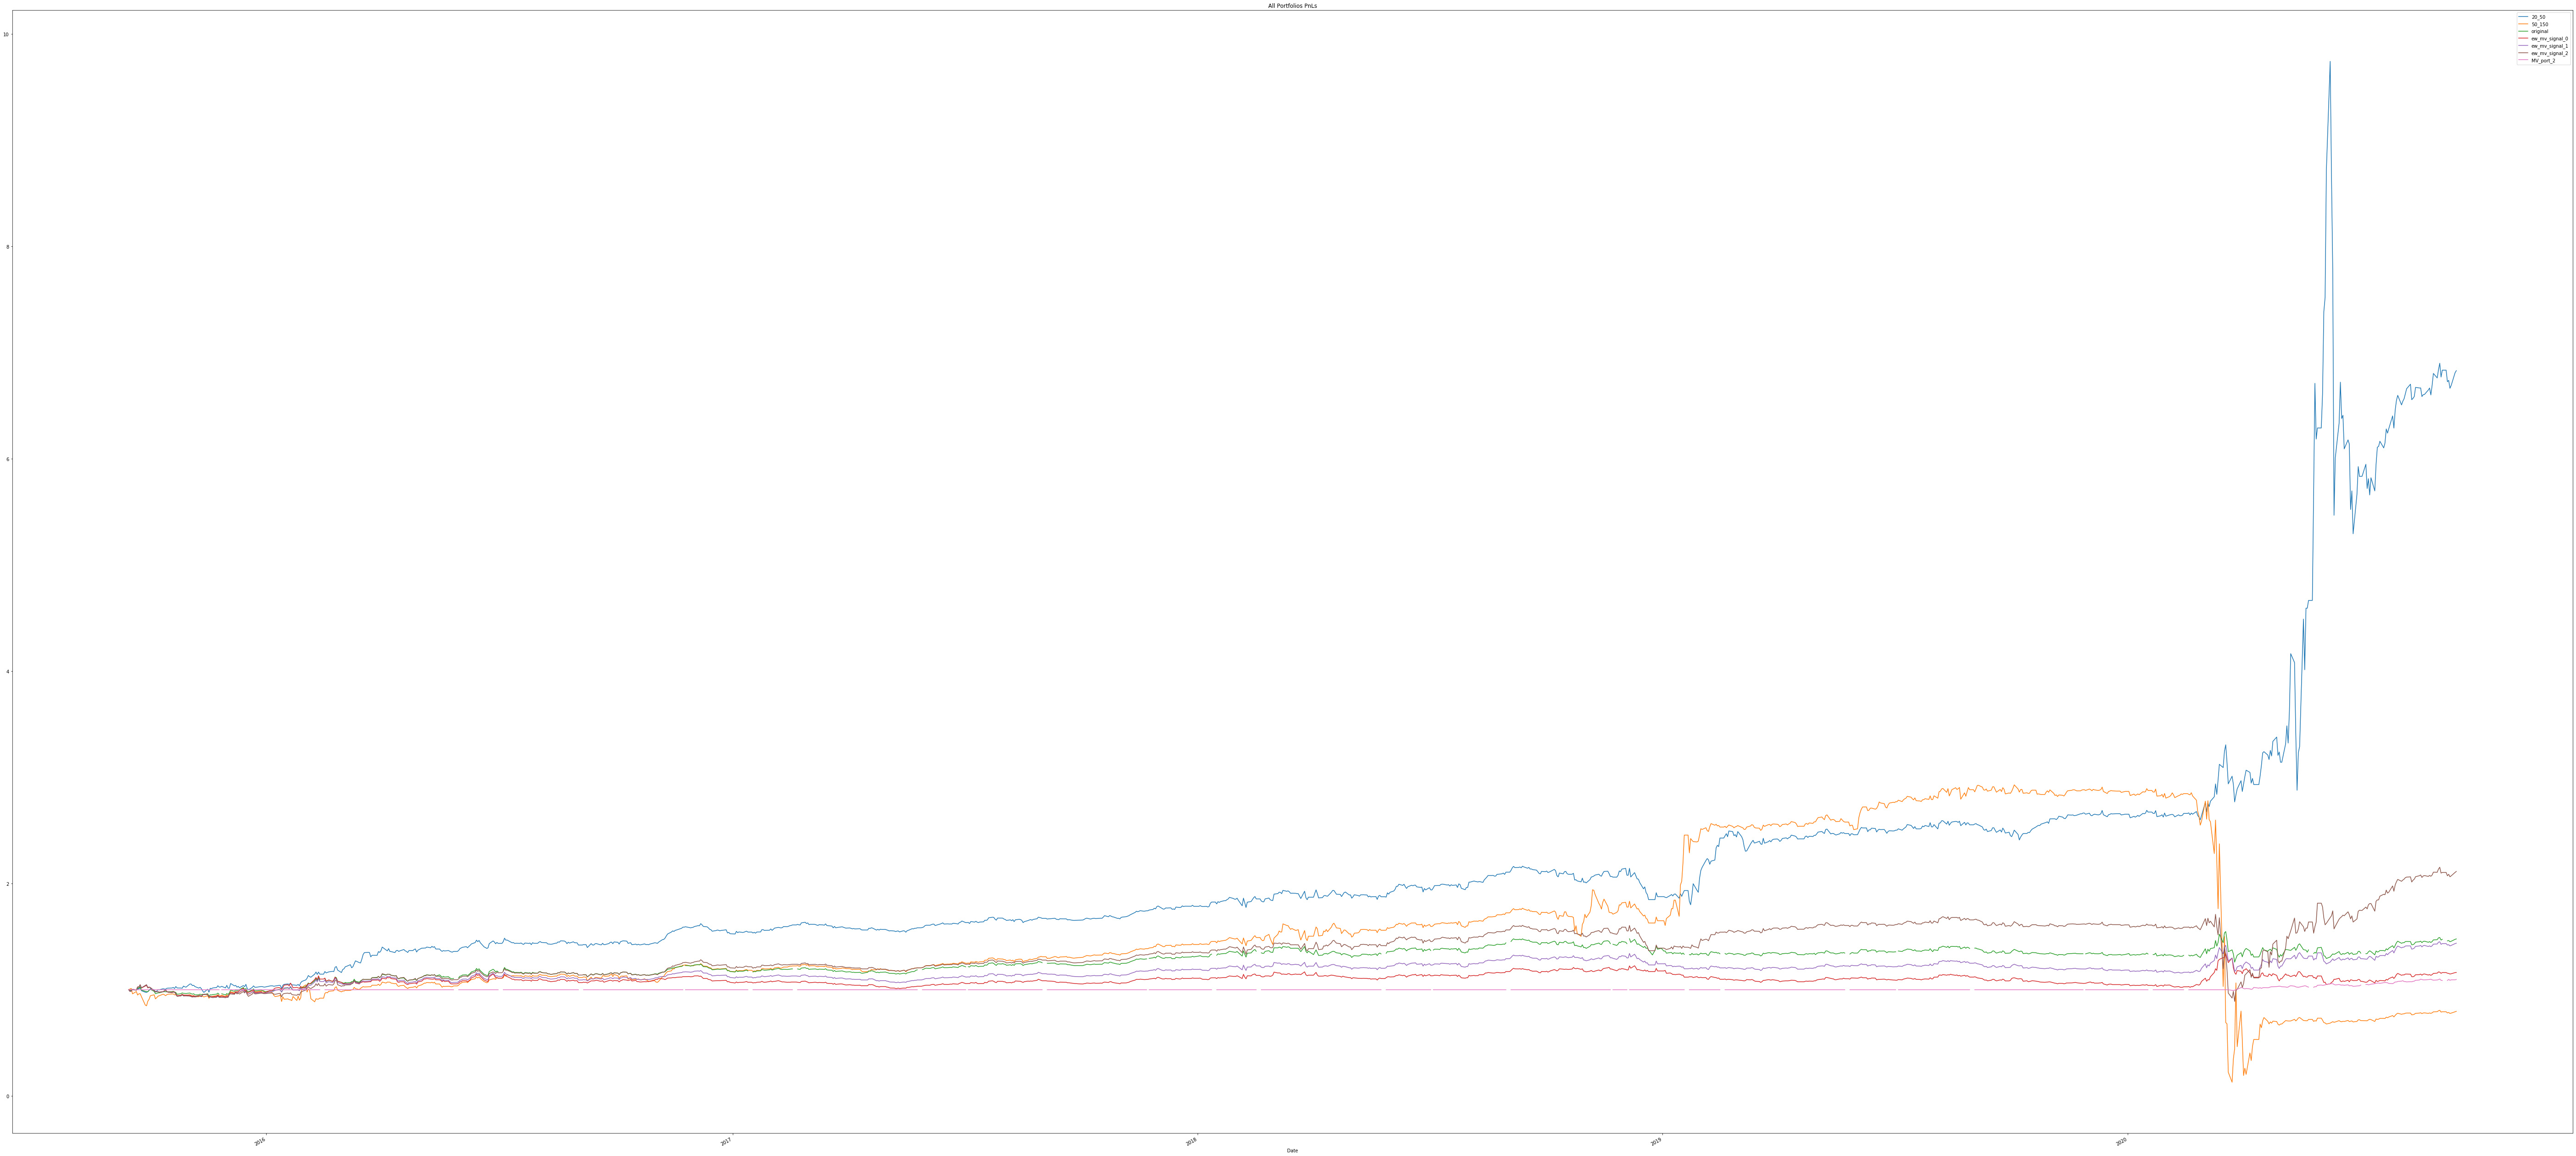

In [38]:
ew_eq_curve_20_50_150.plot(figsize=(100,50), legend=True,title="All Portfolios PnLs")
plt.show()
plt.close()

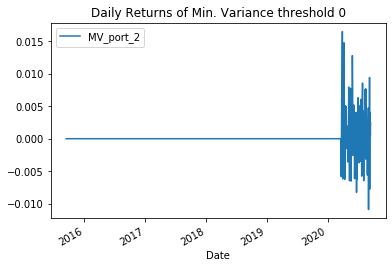

Ending Equity/ Profitability
Date
2020-09-15    1.096438
Name: MV_port_2, dtype: float64
count    1.290000e+03
mean     7.239533e-05
std      1.432720e-03
min     -1.087604e-02
25%     -1.364002e-09
50%      0.000000e+00
75%      1.300017e-09
max      1.645289e-02
Name: MV_port_2, dtype: float64


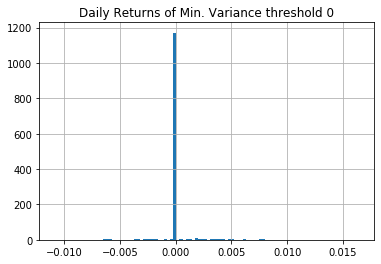

strategy alpha beta
                            OLS Regression Results                            
Dep. Variable:                      p   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     17.16
Date:                Tue, 15 Sep 2020   Prob (F-statistic):           3.66e-05
Time:                        18:01:12   Log-Likelihood:                 6457.1
No. Observations:                1260   AIC:                        -1.291e+04
Df Residuals:                    1258   BIC:                        -1.290e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.301e-05   4.06e-05

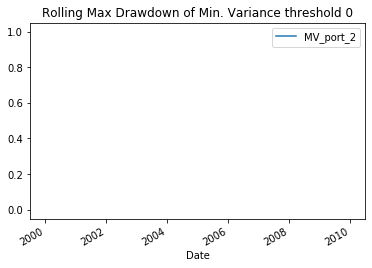

ValueError: min() arg is an empty sequence

In [39]:
performance_analysis(ew_eq_curve_20_50_150['MV_port_2'], (port_ret['Short'] + 1).cumprod(), port_name="Min. Variance threshold 0")